# Prolog

This Jupyter Notebook creates a LSTM-RNN to replicate the Cluster from the Newspaper.ipnyb. It Mainly focuses on identifying relevant newspaper Articles, where dismissals are obvious. 
The Model is stored and will be put into production in a webinterface. 

Author: Ashraf Ibrahim
Changelog: None

# Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline


from tensorflow.python.keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from tensorflow.python.keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from tensorflow.python.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

from tensorflow.python.keras.callbacks import Callback
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.python.keras.preprocessing import text, sequence
from tensorflow.python.keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import merge,add
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from tensorflow.python.client import device_lib
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras import backend as  K


import pydot
import pydotplus 
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from IPython.display import SVG



import re

# Files 

In [3]:
# Read dataframe with Cluster-analysis
df=pd.read_csv('final_frame.csv',sep=';',encoding='latin-1')

In [7]:
df=df.dropna(how='any',axis=0)
df.isna().sum()

Unnamed: 0      0
index           0
Article URL     0
Article Text    0
ORG             0
PER             0
clust           0
0               0
dtype: int64

In [7]:
# Read extracted stopwords_list
stopword=pd.read_csv('stopwords_cluster.csv',sep=';',encoding='latin-1')
# Dataframe to list 
stop_list=stopword['0'].to_list()
stop_list

['aber',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'als',
 'also',
 'am',
 'an',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer',
 'anderes',
 'anderm',
 'andern',
 'anderr',
 'anders',
 'auch',
 'auf',
 'aus',
 'bei',
 'bin',
 'bis',
 'bist',
 'da',
 'damit',
 'dann',
 'der',
 'den',
 'des',
 'dem',
 'die',
 'das',
 'dass',
 'daß',
 'derselbe',
 'derselben',
 'denselben',
 'desselben',
 'demselben',
 'dieselbe',
 'dieselben',
 'dasselbe',
 'dazu',
 'dein',
 'deine',
 'deinem',
 'deinen',
 'deiner',
 'deines',
 'denn',
 'derer',
 'dessen',
 'dich',
 'dir',
 'du',
 'dies',
 'diese',
 'diesem',
 'diesen',
 'dieser',
 'dieses',
 'doch',
 'dort',
 'durch',
 'ein',
 'eine',
 'einem',
 'einen',
 'einer',
 'eines',
 'einig',
 'einige',
 'einigem',
 'einigen',
 'einiger',
 'einiges',
 'einmal',
 'er',
 'ihn',
 'ihm',
 'es',
 'etwas',
 'euer',
 'eure',
 'eurem',
 'euren',
 'eurer',
 'eures',
 'für',
 'gegen',
 'gewesen',
 'hab',
 'habe',
 'haben',
 'hat',
 'hatte',
 'hatten',
 '

# Dataframe preprocssing

In [9]:
# Drop Columns
try:
    df=df.drop(['Unnamed: 0'],axis=1)
except: 
    None

In [10]:
# Rename Column to Cluster
df.rename(columns={'0':'Cluster'},inplace=True)

In [5]:
# Cleaning text
def cleaning(word):
        '''
        Input: 
        Text column
    
        Output:
        tokenized and cleaned text
    
        '''
        # lower words
        word = word.lower()
        
        #### Change Symbols to german Umlaute 
        
        ## Ä 
        word=word.replace('ã¤','ä')

        ## Ö 
        word=word.replace('ã¶','ö')

        ## Ü 
        word=word.replace('ã¼','ü')

        ## ß
        word=word.replace('ÃŸ','ss')
        
        # replace certain symbols
        word = re.sub('[/(){}\[\]\|@,;]', " ", word)
        # remove certain symbols 
        #word = re.sub('[^0-9a-z #+_]','', word)
        # remove +
        word = word.replace('+','')
        # remove digits
        word = re.sub("\d+", " ", word)  
        # Split and anti-join 
        word= ' '.join(w for w in word.split() if w not in stop_list)
        return word

In [12]:
df[df['Article Text'].str.contains('trivago')]

,index,Article URL,Article Text,ORG,PER,clust,Cluster
7,160,https://rp-online.de/wirtschaft/unternehmen/st...,corona-krise trifft reisebranche : hotelsuchma...,"['Corona-Krise', 'Trivago', 'Trivago']","['Hotelsuchmaschine', 'Trivago', 'Bretz', 'And...","(0, 1454)\t0.06453884350546524\n (0, 113)\t...",0.0
4402,3296,https://www.duesseldorf-wirtschaft.de/wirtscha...,die corona-kriese trifft die hotel-metasuchmas...,"['Corona-Pandemie', 'Nasdaq']","['Hotel-Metasuchmaschine', 'Trivago', 'Trivago...","(0, 1454)\t0.06453884350546524\n (0, 113)\t...",0.0


In [13]:
# Grouping text in important and not important
df['Cluster_grp']=np.where(df['Cluster']==0,1,0)

In [14]:
df[df['Article Text'].str.contains('trivago')]

,index,Article URL,Article Text,ORG,PER,clust,Cluster,Cluster_grp
7,160,https://rp-online.de/wirtschaft/unternehmen/st...,corona-krise trifft reisebranche : hotelsuchma...,"['Corona-Krise', 'Trivago', 'Trivago']","['Hotelsuchmaschine', 'Trivago', 'Bretz', 'And...","(0, 1454)\t0.06453884350546524\n (0, 113)\t...",0.0,1
4402,3296,https://www.duesseldorf-wirtschaft.de/wirtscha...,die corona-kriese trifft die hotel-metasuchmas...,"['Corona-Pandemie', 'Nasdaq']","['Hotel-Metasuchmaschine', 'Trivago', 'Trivago...","(0, 1454)\t0.06453884350546524\n (0, 113)\t...",0.0,1


In [15]:
# Applying cleaning to text column
df['Text_cleaned']=df['Article Text'].apply(cleaning)

# LSTM Preprocessing

In [16]:
# Defining features, length-variables etc. 
max_features=50000
max_len=round(min(df['Text_cleaned'].apply(lambda x: len(x))))
embed_size=100
batch_size = 200
epochs = 25

In [ ]:
### Long computational time
# max_len=round(np.mean(df['Text_cleaned'].apply(lambda x: len(x)))) 
# max_len

In [16]:
# Defining tokenizer with filter
tokenizer = text.Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# Fitting Tokenizer
tokenizer.fit_on_texts(df['Text_cleaned'].values)
# Create word index
word_index = tokenizer.word_index
print('Found {} unique words.'.format(len(word_index)))

Found 9422 unique words.


In [18]:
with open("word.json", "w") as outfile:  
    json.dump(word_index, outfile) 

In [31]:
# Defining X 
X = tokenizer.texts_to_sequences(df['Text_cleaned'].values)
X = sequence.pad_sequences(X, maxlen=max_len)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (213, 526)


In [32]:
X.shape

(213, 526)

$$x_{s,w}=\begin{bmatrix}
           x_{w1} \\
           x_{w2} \\
           x_{w3} \\
           \vdots \\
           x_{w526} \\
         \end{bmatrix}$$


In [37]:
X[20]

array([ 129,  151, 2080, 1624,  210, 1013, 1014,  198,  286, 2081,  151,
       1279,   57, 1013,   29, 1014,   19,   23, 1625,   75,  468, 1012,
        780,   68, 1752,  131,  216,   28,  308,  361,  666,   75, 1753,
       1626,    2,    4,  627,  590, 1015, 1270,    7,   13,    9,  145,
       1091,  627,  729, 1015, 1627, 1162,  182,  449,  597, 2082, 2083,
       1373, 2084,  878,  826,  564,  627,   30, 2085,   89, 2086, 2087,
         37, 1628,  940, 2088, 2089, 2090, 1016,  383,   74,  450,   14,
         32, 1353, 1357,    3,  494,   68,  374,  175,  122, 1017, 2091,
       1018,    7,   13,    9,  667,  374,  341,  941,  122, 1017,  730,
         68,  109,  868, 2092, 2093, 1018, 2094, 2095, 2096,  536, 2097,
         19, 1163, 1754, 2098, 2099,   17, 2100, 1629,  628,  149,  537,
        668,   39, 2101,  479,    6, 2102,  629,  179,  448, 1280, 1755,
         39,  332, 1374, 2103,  348,  942, 1019,  943, 1630,  731, 1092,
        319, 1756, 2104,  827, 1631,  943,  629,  3

In [34]:
# Defining Y
Y = pd.get_dummies(df['Cluster_grp']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (213, 2)


In [35]:
# Train-test-split 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42,
                                                    stratify=Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(159, 526) (159, 2)
(54, 526) (54, 2)


# Creating LSTM

## LSTM - One Output

In [37]:
model = Sequential()

# Embedding layer
model.add(Embedding(input_dim=max_features,
              input_length =X.shape[1],
              output_dim=embed_size,
              trainable=False,
              mask_zero=True))

# Recurrent layer
model.add(LSTM(embed_size, return_sequences=True, 
               dropout=0.2, recurrent_dropout=0.2))

# Recurrent layer
model.add(LSTM(embed_size,return_sequences=True))

# Recurrent layer
model.add(LSTM(embed_size))

# Dropout Layer
model.add(Dropout(rate=0.2))

# Output layer
model.add(Dense(Y.shape[1], activation='softmax'))


# Compile the model
model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
from tensorflow.keras.utils import plot_model

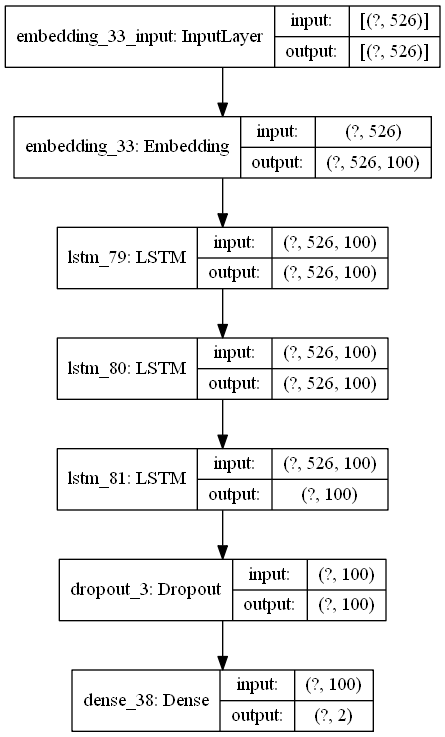

In [113]:
plot_model(model, show_shapes=True)

In [106]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 526, 100)          5000000   
_________________________________________________________________
lstm_21 (LSTM)               (None, 526, 100)          80400     
_________________________________________________________________
lstm_22 (LSTM)               (None, 526, 100)          80400     
_________________________________________________________________
lstm_23 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 5,241,402
Trainable params: 241,402
Non-trainable params: 5,000,000
_____________________________________

## LSTM - Two Output

In [44]:
m_input=Input(shape=(X.shape[1],),dtype='int32',name='main_Input')

model_2=Embedding(input_dim=max_features,
              input_length =X.shape[1],
              output_dim=embed_size,
              trainable=False,
              mask_zero=True)(m_input)

lstm_1=LSTM(embed_size, return_sequences=True, 
               dropout=0.2, recurrent_dropout=0.2)(model_2)

lstm_2=LSTM(embed_size, return_sequences=True)(lstm_1)

lstm_3=LSTM(embed_size)(lstm_1)

aux_output=Dense(Y.shape[1], activation='softmax',name='aux_Output')(lstm_3)

lstm_4=LSTM(embed_size)(lstm_2)

main_output=Dense(Y.shape[1], activation='softmax',name='main_Output')(lstm_4)

Two_output=Model(m_input, [main_output,aux_output])
Two_output.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

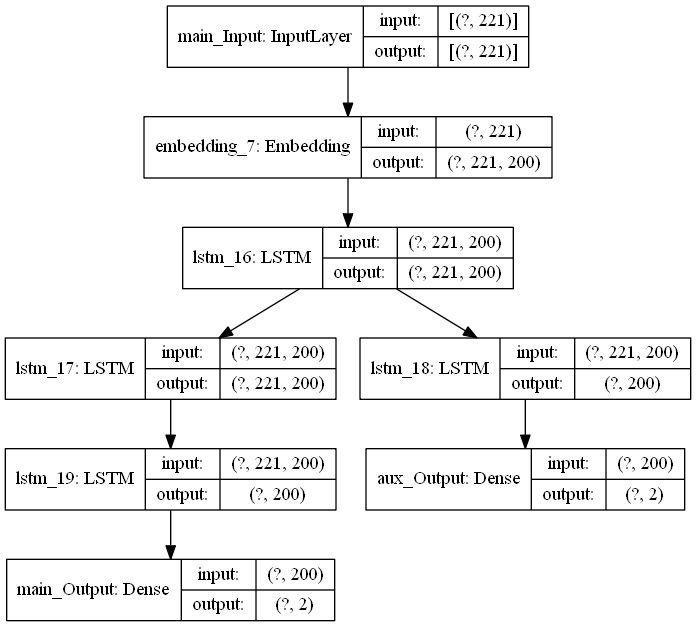

In [45]:
plot_model(Two_output, show_shapes=True)

In [41]:
Two_output.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_Input (InputLayer)         [(None, 221)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 221, 200)     10000000    main_Input[0][0]                 
__________________________________________________________________________________________________
lstm_12 (LSTM)                  (None, 221, 200)     320800      embedding_6[0][0]                
__________________________________________________________________________________________________
lstm_13 (LSTM)                  (None, 221, 200)     320800      lstm_12[0][0]                    
______________________________________________________________________________________________

# Running LSTM 

## Basic Model

In [50]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='loss', patience=10, min_delta=0.0001)], 
                    verbose=2,validation_data=(X_test,Y_test))

Epoch 1/25
1/1 - 2s - loss: 0.6930 - accuracy: 0.5385 - val_loss: 0.6948 - val_accuracy: 0.3750
Epoch 2/25
1/1 - 0s - loss: 0.6915 - accuracy: 0.5035 - val_loss: 0.6962 - val_accuracy: 0.3750
Epoch 3/25
1/1 - 0s - loss: 0.6895 - accuracy: 0.5035 - val_loss: 0.6960 - val_accuracy: 0.3750
Epoch 4/25
1/1 - 0s - loss: 0.6877 - accuracy: 0.5035 - val_loss: 0.6916 - val_accuracy: 0.4375
Epoch 5/25
1/1 - 0s - loss: 0.6836 - accuracy: 0.5664 - val_loss: 0.6817 - val_accuracy: 0.7500
Epoch 6/25
1/1 - 0s - loss: 0.6776 - accuracy: 0.8042 - val_loss: 0.6655 - val_accuracy: 0.8125
Epoch 7/25
1/1 - 0s - loss: 0.6669 - accuracy: 0.7343 - val_loss: 0.6524 - val_accuracy: 0.7500
Epoch 8/25
1/1 - 0s - loss: 0.6528 - accuracy: 0.7762 - val_loss: 0.6456 - val_accuracy: 0.6875
Epoch 9/25
1/1 - 0s - loss: 0.6262 - accuracy: 0.8042 - val_loss: 0.6015 - val_accuracy: 0.8125
Epoch 10/25
1/1 - 0s - loss: 0.5898 - accuracy: 0.7622 - val_loss: 0.5254 - val_accuracy: 0.7500
Epoch 11/25
1/1 - 0s - loss: 0.5658 - a

Note: Huge accuracy increase after 10th epoch. 

In [52]:
# Saving Model 
model.save('newspaper.h5')

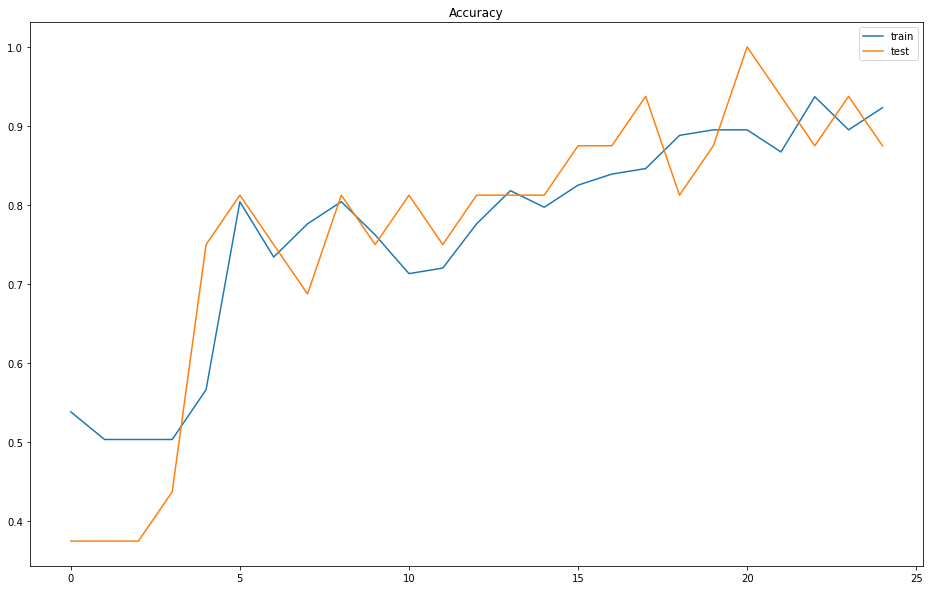

In [53]:
# Evaluating Accuracy 
plt.figure(figsize=(16,10))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Alternative Model

In [128]:
history_2 = Two_output.fit(X_train, Y_train, epochs=30, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='loss', patience=10, min_delta=0.0001)], 
                    verbose=2,validation_data=(X_test,Y_test))

Epoch 1/30
1/1 - 0s - loss: 0.3332 - main_Output_loss: 0.1238 - aux_Output_loss: 0.2094 - main_Output_accuracy: 0.9301 - aux_Output_accuracy: 0.9371 - val_loss: 0.4472 - val_main_Output_loss: 0.2163 - val_aux_Output_loss: 0.2309 - val_main_Output_accuracy: 0.9375 - val_aux_Output_accuracy: 0.9375
Epoch 2/30
1/1 - 0s - loss: 0.2837 - main_Output_loss: 0.1068 - aux_Output_loss: 0.1769 - main_Output_accuracy: 0.9650 - aux_Output_accuracy: 0.9510 - val_loss: 0.4958 - val_main_Output_loss: 0.2975 - val_aux_Output_loss: 0.1983 - val_main_Output_accuracy: 0.8750 - val_aux_Output_accuracy: 0.8750
Epoch 3/30
1/1 - 0s - loss: 0.2724 - main_Output_loss: 0.1215 - aux_Output_loss: 0.1509 - main_Output_accuracy: 0.9580 - aux_Output_accuracy: 0.9580 - val_loss: 0.4116 - val_main_Output_loss: 0.2444 - val_aux_Output_loss: 0.1671 - val_main_Output_accuracy: 0.8750 - val_aux_Output_accuracy: 0.9375
Epoch 4/30
1/1 - 0s - loss: 0.2212 - main_Output_loss: 0.0866 - aux_Output_loss: 0.1347 - main_Output_accu

Epoch 29/30
1/1 - 0s - loss: 0.0865 - main_Output_loss: 0.0421 - aux_Output_loss: 0.0444 - main_Output_accuracy: 0.9860 - aux_Output_accuracy: 0.9790 - val_loss: 0.0440 - val_main_Output_loss: 0.0214 - val_aux_Output_loss: 0.0225 - val_main_Output_accuracy: 1.0000 - val_aux_Output_accuracy: 1.0000
Epoch 30/30
1/1 - 0s - loss: 0.0464 - main_Output_loss: 0.0154 - aux_Output_loss: 0.0310 - main_Output_accuracy: 0.9930 - aux_Output_accuracy: 0.9860 - val_loss: 0.0240 - val_main_Output_loss: 0.0135 - val_aux_Output_loss: 0.0105 - val_main_Output_accuracy: 1.0000 - val_aux_Output_accuracy: 1.0000


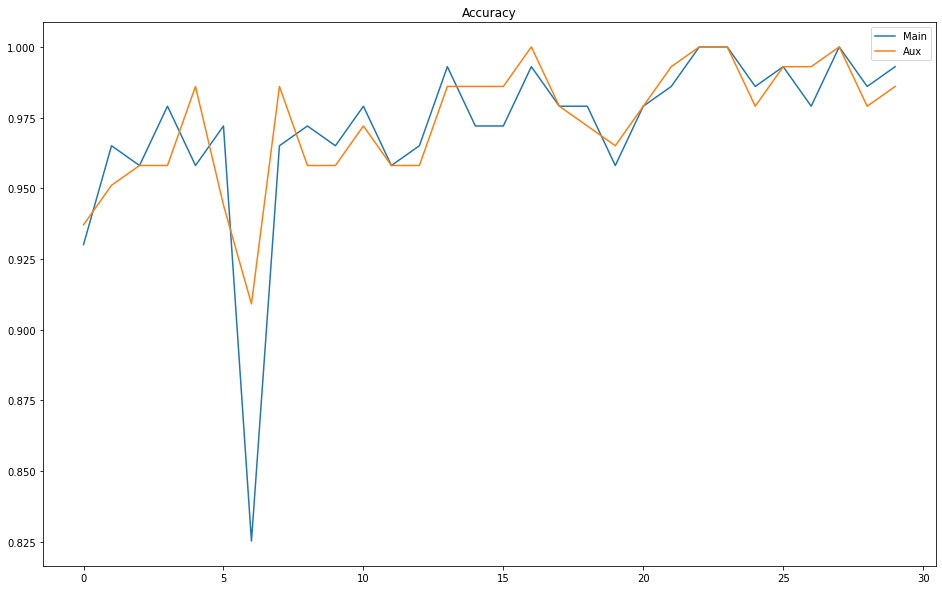

In [129]:
# Evaluating Accuracy 
plt.figure(figsize=(16,10))
plt.title('Accuracy')
plt.plot(history_2.history['main_Output_accuracy'], label='Main')
plt.plot(history_2.history['aux_Output_accuracy'], label='Aux')
plt.legend()
plt.show();